## imports

In [4]:
!pip install psynlig
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.metrics import recall_score, precision_score, f1_score, cohen_kappa_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from psynlig import pca_residual_variance
import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.8 MB 14.6 MB/s 
     |████████████████████████████████| 6.5 MB 15.1 MB/s 
  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7097 sha256=befa559c12d1777853fd7abf877644dead0c5d31af1e3b774525d6dce02a5528
  Stored in directory: /root/.cache/pip/wheels/2f/98/32/afbf902d8f040fadfdf0a44357e4ab750afe165d873bf5893d
  Created wheel for sphinx-gallery: filename=sphinx_gallery-0.10.1-py3-none-any.whl size=132569 sha256=e5c6d171b134b8be1e7ff62ec841837d0791f103a1f65517d5908a150ce0c0ca
  Stored in directory: /root/.cache/pip/wheels/52/72/6f/d5817eb58b7f5a43cc40b0186bbfa9ce3ea9cdbd9881c7cd50
Successfully built adjustText sphinx-gallery


## preprocessing of KDD dataset

In [5]:
df = pd.read_csv(r"../data/kddcup99.csv",index_col=0).reset_index(drop=True)
df = df.sample(n = 40000, random_state=31).reset_index(drop=True)
np.random.seed(42)
# change of decision variable classes by tagging 0 for normal and 1 for fraud ----just for kdd----
df.loc[(df.label !="normal"),"target"] = 1
df.loc[(df.label =="normal"),"target"] = 0
df = df.drop(['label'], axis=1)
feat_df = df.drop(['target'], axis=1)
label_df = df.target
# convert categorical features to binary
obj_df = feat_df.select_dtypes(include=['object']).copy()
categorical_df = pd.DataFrame()
for c in range(len(obj_df.columns)) :
    col = obj_df.columns[c]
    cat_df = pd.get_dummies(feat_df[col]).reset_index(drop=True) 
    cat_df = cat_df.iloc[:, :-1]
    categorical_df = pd.concat([categorical_df, cat_df], axis=1)    
features_df = feat_df.drop(obj_df.columns, axis=1)
features_df = pd.concat([features_df, categorical_df], axis=1) 
col_name = features_df.columns  
del categorical_df , obj_df
### normalizing
features_df = pd.DataFrame(scale(features_df))
features_df.columns = col_name
x_train, x_test, y_train, y_test = train_test_split(features_df, label_df, train_size = 0.7, random_state = 42)  
train_df = pd.concat([x_train, y_train], axis=1).reset_index(drop = True) 
test_df = pd.concat([x_test, y_test], axis=1).reset_index(drop = True)

## Residual variance -> Dimensionality Reduction with Principal Component Analysis

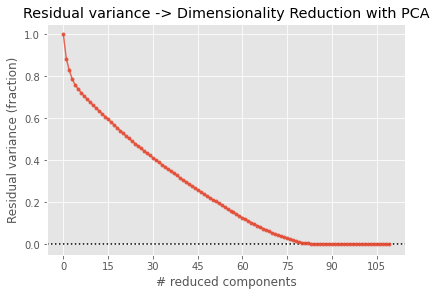

In [6]:
plt.style.use('ggplot')
pca = PCA()
pca.fit_transform(x_train)
pca_residual_variance(pca, marker='o', markersize=3, alpha=0.8)
plt.xlabel("# reduced components")
plt.title("Residual variance -> Dimensionality Reduction with PCA")
plt.show()

## Balance check

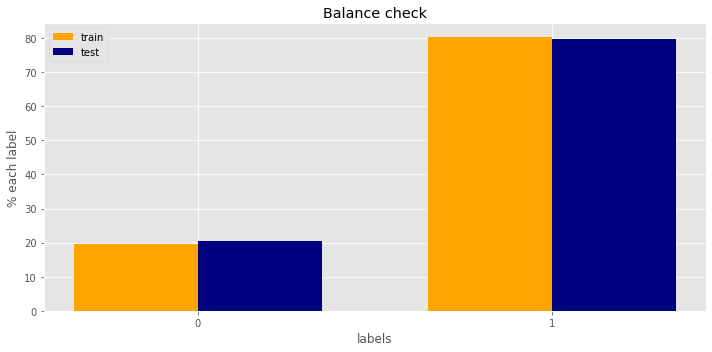

       train       test
0  19.721429  20.391667
1  80.278571  79.608333


In [12]:
train_frauds = (sum(train_df.target)/len(train_df))*100
train_norms = 100 - train_frauds
test_frauds = (sum(test_df.target)/len(test_df))*100
test_norms = 100 - test_frauds
train_per = (train_norms, train_frauds)
test_per = (test_norms, test_frauds)
fig, ax = plt.subplots(figsize = (10, 5))
index = np.arange(2)
bar_width = 0.35
rects1 = plt.bar(index, train_per, bar_width, color='orange', label='train')
rects2 = plt.bar(index + bar_width, test_per, bar_width, color='navy',label='test')
plt.xlabel('labels')
plt.ylabel('% each label')
plt.title('Balance check')
plt.xticks(index + 0.5*bar_width, ('0', '1'))
plt.legend()
plt.tight_layout()
plt.show()
print(pd.DataFrame({'train' : train_per, 'test' : test_per}))

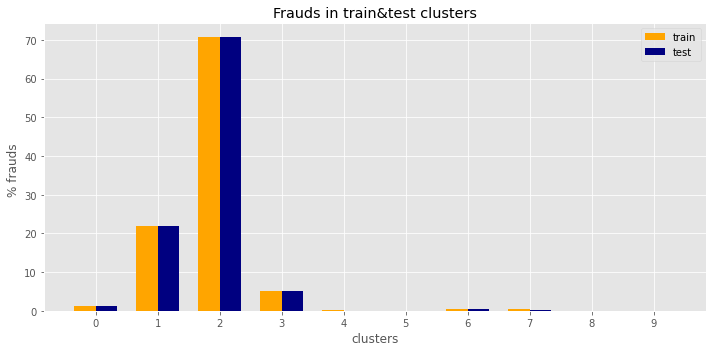

   % train_frauds  %test_frauds
0        1.134443      1.130535
1       21.888068     21.972155
2       70.753626     70.752643
3        5.231782      5.213022
4        0.097873      0.073275
5        0.013346      0.020936
6        0.444879      0.471056
7        0.364801      0.314037
8        0.044488      0.020936
9        0.026693      0.031404


In [13]:
x_all = pd.concat([x_train, x_test], axis=0).reset_index(drop = True)
cluster = 10
data = np.array(x_all).reshape(-1, x_all.shape[1])
km = KMeans(n_clusters = 10, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
x_all['cluster_group'] = km.fit_predict(data).tolist()
train_df['cluster_group'] = x_all['cluster_group'][:len(x_train)].reset_index(drop = True)
test_df['cluster_group'] = x_all['cluster_group'][len(x_train):].reset_index(drop = True)
train_fraud = []
test_fraud = []
for i in range(cluster):
    df_1 = train_df[train_df['cluster_group']==i]
    train_fraud.append(100*sum(df_1.target)/sum(train_df.target))
for i in range(cluster):
    df_1 = test_df[test_df['cluster_group']==i]
    test_fraud.append(100*sum(df_1.target)/sum(test_df.target))
fig, ax = plt.subplots(figsize = (10, 5))
index = np.arange(10)
bar_width = 0.35
rects1 = plt.bar(index, train_fraud, bar_width, color='orange', label='train')
rects2 = plt.bar(index + bar_width, test_fraud, bar_width, color='navy',label='test')
plt.xlabel('clusters')
plt.ylabel('% frauds ')
plt.title('Frauds in train&test clusters')
plt.xticks(index + 0.5*bar_width, ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9'))
plt.legend()
plt.tight_layout()
plt.show()
print(pd.DataFrame({'% train_frauds' : train_fraud, '%test_frauds' : test_fraud}))

## Error analysis

unsupervised anomaly detection model : One-Class Support Vector Machines

train_step :

In [9]:
np.random.seed(31)
svm_model = svm.OneClassSVM()
svm_model.fit(x_train)
svm_pred = svm_model.predict(x_train)
svm_pred = pd.Series(svm_pred).replace([-1,1],[1,0])
svm_conf_mat = pd.DataFrame(confusion_matrix(y_train, svm_pred))
print('*********confusion_matrix*********')
print(svm_conf_mat)
index = []
test_score = []
valid_score = []   
index.append("recall_score")
test_score.append(recall_score(y_train, svm_pred)) 
index.append("precision_score")
test_score.append(precision_score(y_train, svm_pred))
index.append("f1_score")
test_score.append(f1_score(y_train, svm_pred))  
index.append("cohen_kappa_score")
test_score.append(cohen_kappa_score(y_train, svm_pred))
index.append("roc_auccuracy_score")
test_score.append(roc_auc_score(y_train, svm_pred))
### summary scores in dataframe 
print('*********scores *********')
print(pd.DataFrame({"index":index ,"score" :test_score }))
y_df_train = pd.DataFrame(y_train).reset_index(drop = True)
y_df_train['pred_label'] = svm_pred
clusters = train_df.cluster_group.reset_index()
y_df_train['cluster_group'] = clusters.cluster_group
per_error_train = []
for j in range(cluster):
    df = y_df_train[y_df_train.cluster_group == j]
    fr_df = df[df.target == 1]
    real = max(len(fr_df.target) , 1)
    err = len(fr_df[fr_df.pred_label == 0])
    per_error_train.append(100*err/real)

*********confusion_matrix*********
      0      1
0   790   4732
1  3546  18932
*********scores *********
                 index     score
0         recall_score  0.842246
1      precision_score  0.800034
2             f1_score  0.820597
3    cohen_kappa_score -0.015985
4  roc_auccuracy_score  0.492655


test step

In [10]:
svm_pred_test = svm_model.predict(x_test)
svm_pred_test = pd.Series(svm_pred_test).replace([-1,1],[1,0])
svm_conf_mat_test = pd.DataFrame(confusion_matrix(y_test, svm_pred_test))
print('*********confusion_matrix*********')
print(svm_conf_mat_test)
index = []
test_score = []
valid_score = []   
index.append("recall_score")
test_score.append(recall_score(y_test, svm_pred_test)) 
index.append("precision_score")
test_score.append(precision_score(y_test, svm_pred_test))
index.append("f1_score")
test_score.append(f1_score(y_test, svm_pred_test))  
index.append("cohen_kappa_score")
test_score.append(cohen_kappa_score(y_test, svm_pred_test))
index.append("roc_auccuracy_score")
test_score.append(roc_auc_score(y_test, svm_pred_test))
### summary scores in dataframe 
print('*********scores *********')
print(pd.DataFrame({"index":index ,"score" :test_score }))
y_df_test = pd.DataFrame(y_test).reset_index(drop = True)
y_df_test['pred_label'] = svm_pred_test
clusters = test_df.cluster_group.reset_index()
y_df_test['cluster_group'] = clusters.cluster_group
per_error_tset = []
for j in range(cluster):
    df = y_df_test[y_df_test.cluster_group == j]
    fr_df = df[df.target == 1]
    real = max(len(fr_df.target) , 1)
    err = len(fr_df[fr_df.pred_label == 0])
    per_error_tset.append(100*err/real)

*********confusion_matrix*********
      0     1
0   353  2094
1  1445  8108
*********scores *********
                 index     score
0         recall_score  0.848739
1      precision_score  0.794746
2             f1_score  0.820855
3    cohen_kappa_score -0.007770
4  roc_auccuracy_score  0.496498


Display "% False Negative /  all_real_fraud" in each *cluster*

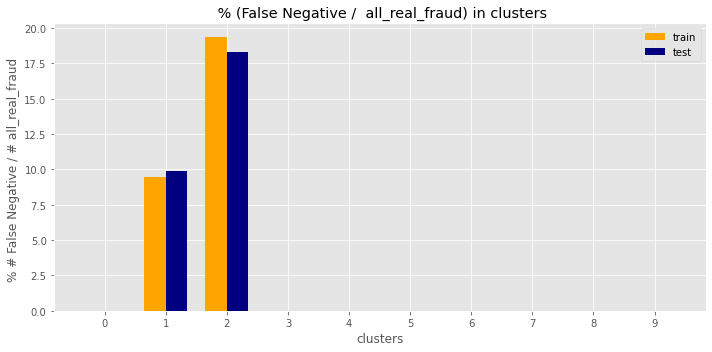

       train       test
0   0.000000   0.000000
1   9.471545   9.909481
2  19.366197  18.301524
3   0.000000   0.000000
4   0.000000   0.000000
5   0.000000   0.000000
6   0.000000   0.000000
7   0.000000   0.000000
8   0.000000   0.000000
9   0.000000   0.000000


In [14]:
fig, ax = plt.subplots(figsize = (10, 5))
index = np.arange(10)
bar_width = 0.35
rects1 = plt.bar(index, per_error_train, bar_width, color='orange', label='train')
rects2 = plt.bar(index + bar_width, per_error_tset, bar_width, color='navy',label='test')
plt.xlabel('clusters')
plt.ylabel('% # False Negative / # all_real_fraud ')
plt.title(' % (False Negative /  all_real_fraud) in clusters')
plt.xticks(index + 0.5*bar_width, ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9'))
plt.legend()
plt.tight_layout()
plt.show()
print(pd.DataFrame({'train' : per_error_train, 'test' : per_error_tset}))